## Big Data Analytics
## Assignment 1: Airbnb Listing Price Prediction


### Overview

* **Objective**: Predicting the listing price based on the listing features.
* **Data**: Airbnb listing data from San Diego, CA, United States.

### Data Description

The dataset has 6110 rows and 20 columns. The target variable we want to predict is **price** (in US dollars per night). **log_price** is the natural logarithm of **price**. They are essentially the same variable. Most of the columns are self-explanatory. A few notes about the less clear ones:
* **accomodates** indicates how many people the listing can accomodate.
* **d2balboa** indicates the distance (in km) to Balboa Park (which is in the city center).
* **pool** indicates whether the listing has a pool .
* **coastal** indicates whether the listing is near the coast.
* Columns starting with "pg" indicate the property type, and columns starting with "rt" indicate the room type.
* **geometry** indicates the location of the listing.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

import folium

d:\00-Software\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
d:\00-Software\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Questions

1. **Data Exploration**: Visualize the spatial distribution of Airbnb listings on a map (e.g. scatter plot). Add any insights you can find from the plot. (3 points)


2. **Baseline Model**: Develop a linear regression model (OLS) to predict **price**. Split the dataset into training (75%) and testing (25%) sets, and clarify the model evaluation metrics. Find a set of features that give you a good predictive performance. Please include the **neighborhood** variable in your feature selection. (5 points)


3. **Model Interpretation**: Interpret the OLS coefficients (based on model training in Q2) and identify the most important features. You should clarify how you measure the importance of a feature, and comment on the results (e.g. whether the coefficients make sense). (4 points)


4. **Model Tuning**: Use Ridge and Lasso for price prediction. Compare them with OLS, and explain the difference. You should tune the regularization hyperparameters based on cross-validation. (4 points)


5. **Model Diagnosis**: Get the best model from Q3, and analyze the patterns of its errors. Based on the analysis, propose 1-2 potential improvements to the model. (2 points)

6. **Alternative Approach**: Now let us change the target variable from **price** to **log_price** and repeat Q2 (with the same features). How would you compare the two approaches? (2 points)

In [2]:
data = gpd.read_file('regression_db.geojson')
data.head()

accommodates  bathrooms  bedrooms  beds neighborhood  pool   d2balboa  \
0             5        2.0       2.0   2.0  North Hills     0   2.972077   
1             6        1.0       2.0   4.0  Mission Bay     0  11.501385   
2             2        1.0       1.0   1.0  North Hills     0   2.493893   
3             2        1.0       1.0   1.0    Mira Mesa     0  22.293757   
4             2        1.0       1.0   1.0    Roseville     0   6.829451   

   coastal  price  log_price     id  pg_Apartment  pg_Condominium  pg_House  \
0        0  425.0   6.052089      6             0               0         1   
1        1  205.0   5.323010   5570             0               1         0   
2        0   99.0   4.595120   9553             1               0         0   
3        0   72.0   4.276666  14668             0               0         1   
4        0   55.0   4.007333  38245             0               0         1   

   pg_Other  pg_Townhouse  rt_Entire_home/apt  rt_Private_room  \
0         0             0                   1                0   
1         0             0                   1                0   
2         0             0                   0                1   
3         0             0                   0                1   
4         0             0                   0                1   

   rt_Shared_room                     geometry  
0               0  POINT (-117.12971 32.75399)  
1               0  POINT (-117.25253 32.78421)  
2               0  POINT (-117.14121 32.75327)  
3               0  POINT (-117.15269 32.93110)  
4               0  POINT (-117.21870 32.74202)

In [3]:
data.shape

(6110, 20)

### Q1.Data Exploration  
Below shows a plot of circles on map, each representing an Airbnb listing. The area of the circle is proportional to the price of the listing, and the color indicates the number of bedrooms (blue for 1 bedroom, purple for 2 bedrooms, and red for 3 or more bedrooms). From this map, it is clear that the listings near the coast are generally more expensive but also have more bedrooms.

In [5]:
lng_map = data['geometry'].x.mean()
lat_map = data['geometry'].y.mean()

m = folium.Map(location=[lat_map, lng_map],  # state the initial coordinates of the map location
               tiles='cartodbpositron',  # choose the style of the base map
               zoom_start=12)  # zoom the map to the ideal scale

for index, row in data.iterrows():
    _radius = np.sqrt(row['price']) * 0.1
    if np.isnan(_radius):
        _radius = 0
    
    if row['bedrooms'] == 1:
        _color = '#81D8D0' # tiffany blue
    elif row['bedrooms'] == 2:
        _color = '#800080' # purple
    else:
        _color = '#E80018' # target red

    lat, lon = row['geometry'].y, row['geometry'].x

    folium.CircleMarker(location = [lat, lon],
                        radius = _radius,
                        color = _color,
                        opacity = 0.6).add_to(m)

m

 To further dig out the implicit correlation of the Airbnb dataset, I utilized the heatmap function. The Correlation Between Variables Plot shows that the price has a stronger correlation between accommodates, bathrooms, bedrooms, and beds variables.

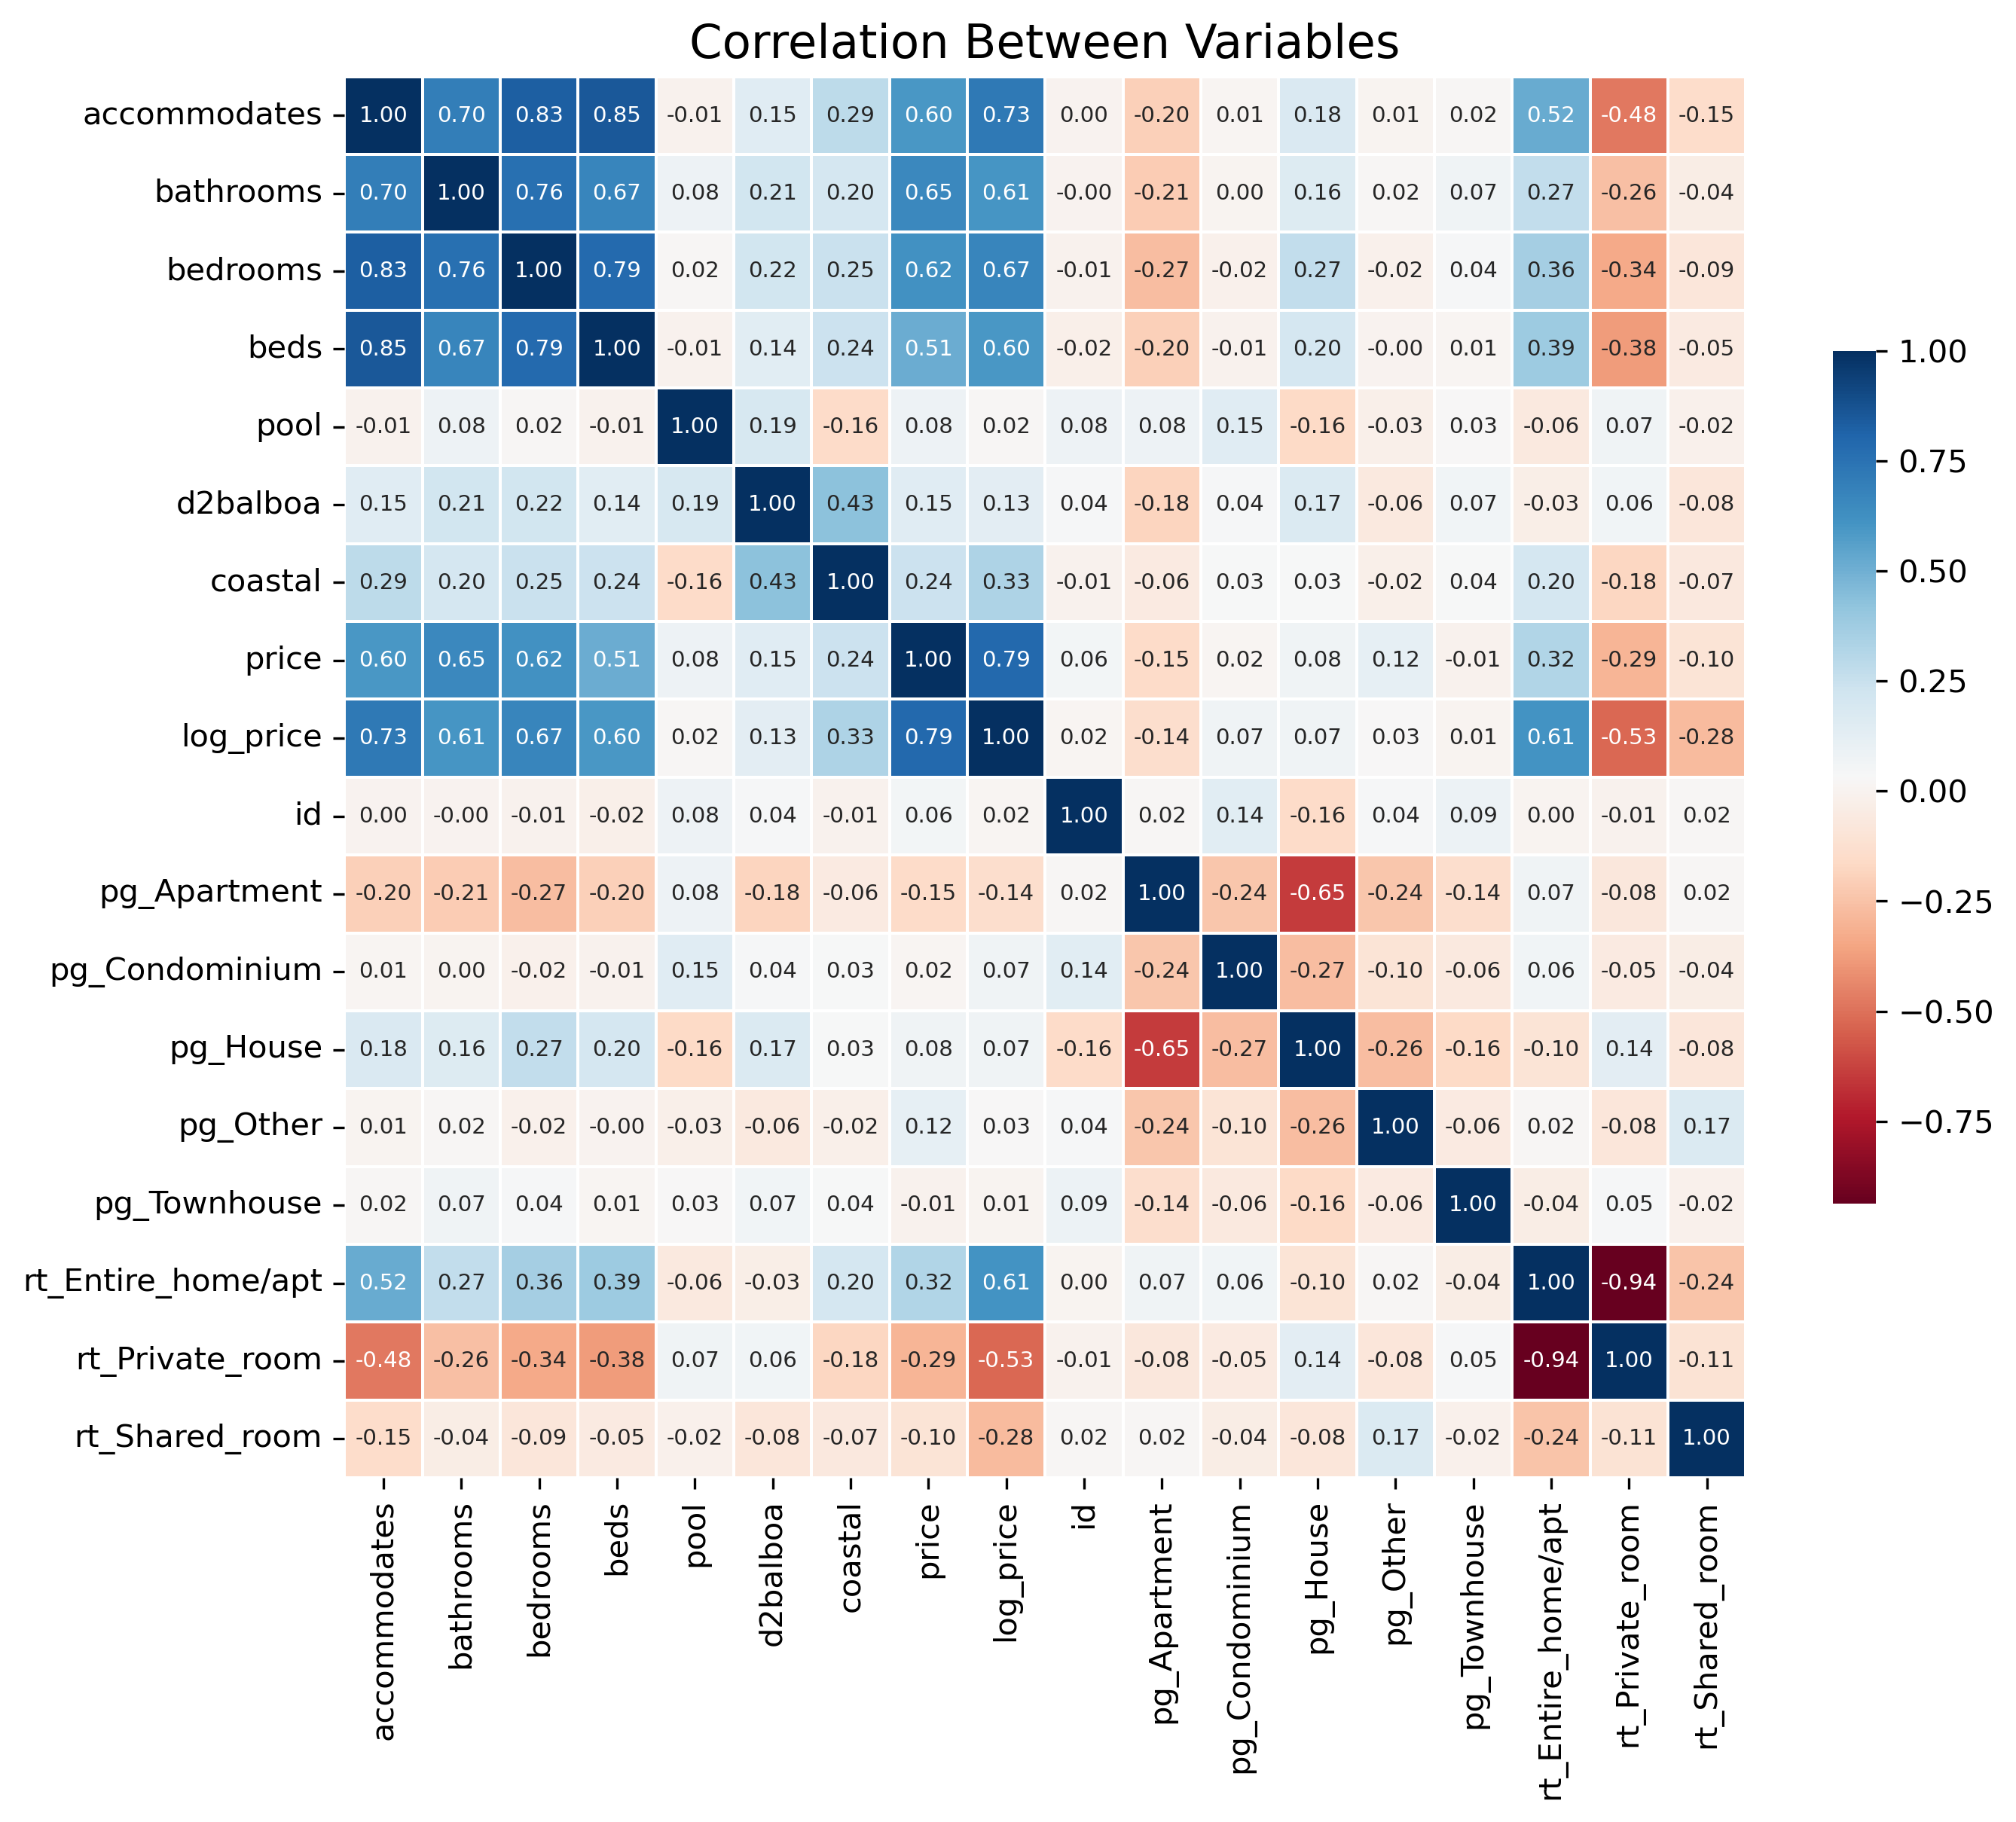

In [46]:
plt.figure(figsize=(10,10),dpi=300)
sns.heatmap(data.corr(method="pearson"), cmap="RdBu",square=True,
            linewidths=.5, annot=True, fmt=".2f",
            annot_kws={"fontsize":7}, cbar_kws={"shrink": 0.5})
plt.title("Correlation Between Variables Plot", size=15)
plt.show()

### Q2. Baseline Model

In [5]:
# convert the neighborhood variable to a collection of dummy variables
data2 = pd.get_dummies(data, columns=['neighborhood'], prefix = ['neighborhood'])
data2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 64 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   accommodates                          6110 non-null   int64   
 1   bathrooms                             6110 non-null   float64 
 2   bedrooms                              6110 non-null   float64 
 3   beds                                  6110 non-null   float64 
 4   pool                                  6110 non-null   int64   
 5   d2balboa                              6110 non-null   float64 
 6   coastal                               6110 non-null   int64   
 7   price                                 6110 non-null   float64 
 8   log_price                             6110 non-null   float64 
 9   id                                    6110 non-null   int64   
 10  pg_Apartment                          6110 non-null   int64   
 

In [8]:
neighborhood_cols = [s for s in data2.columns if s.startswith('neighborhood_')]
pg_cols = [s for s in data2.columns if s.startswith('pg_')]
rt_cols = [s for s in data2.columns if s.startswith('rt_')]
numeric_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'pool', 'd2balboa', 'coastal']
feature_names = numeric_cols + pg_cols[0:] + rt_cols[0:] + neighborhood_cols[0:]

# standardize
scaler = StandardScaler()
data2[numeric_cols] = scaler.fit_transform(data2[numeric_cols])

In [10]:
X = data2[feature_names]
y = data2['price']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle=True,
                                                    test_size=0.25, 
                                                    random_state=123)
print(len(X_train))
print(len(X_test))

4582
1528


In [59]:
X_train

accommodates  bathrooms  bedrooms      beds      pool  d2balboa  \
2357     -0.781837  -0.550270 -0.518596 -0.698514 -0.491546  0.737159   
3281      0.626380  -0.550270  0.361577  0.469180  2.034397  2.231449   
1155     -0.781837   0.028613  0.361577 -0.114667 -0.491546 -0.940389   
1554     -0.429783  -0.550270 -0.518596 -0.698514 -0.491546 -0.356469   
4218      2.738706   7.554089  3.882267  2.220722 -0.491546  1.303619   
...            ...        ...       ...       ...       ...       ...   
5218      1.330489   0.607495  2.121922  1.636875 -0.491546  0.379823   
4060     -0.077729  -0.550270 -0.518596 -0.114667 -0.491546 -1.149666   
1346     -0.077729  -0.550270 -0.518596 -0.114667 -0.491546  0.238731   
3454      2.034597   0.607495  1.241749  1.636875  2.034397  1.225130   
3582      0.626380   0.607495  0.361577  0.469180 -0.491546  0.164125   

       coastal  pg_Apartment  pg_Condominium  pg_House  ...  \
2357  1.286162             1               0         0  ...   
3281 -0.777507             0               1         0  ...   
1155 -0.777507             0               0         1  ...   
1554 -0.777507             0               0         1  ...   
4218  1.286162             0               0         0  ...   
...        ...           ...             ...       ...  ...   
5218  1.286162             1               0         0  ...   
4060 -0.777507             1               0         0  ...   
1346  1.286162             1               0         0  ...   
3454 -0.777507             0               0         0  ...   
3582  1.286162             0               0         1  ...   

      neighborhood_Park West  neighborhood_Rancho Bernadino  \
2357                       0                              0   
3281                       0                              0   
1155                       0                              0   
1554                       0                              0   
4218                       0                              0   
...                      ...                            ...   
5218                       0                              0   
4060                       0                              0   
1346                       0                              0   
3454                       0                              0   
3582                       0                              0   

      neighborhood_Rancho Penasquitos  neighborhood_Roseville  \
2357                                0                       0   
3281                                0                       0   
1155                                0                       0   
1554                                0                       0   
4218                                0                       0   
...                               ...                     ...   
5218                                0                       0   
4060                                0                       0   
1346                                0                       0   
3454                                0                       0   
3582                                0                       0   

      neighborhood_San Carlos  neighborhood_Scripps Ranch  \
2357                        0                           0   
3281                        0                           0   
1155                        0                           0   
1554                        0                           0   
4218                        0                           0   
...                       ...                         ...   
5218                        0                           0   
4060                        0                           0   
1346                        0                           0   
3454                        0                           0   
3582                        0                           0   

      neighborhood_Serra Mesa  neighborhood_South Park  \
2357                        0              

In [12]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    rmse = mean_squared_error(y_train, predictions, squared=False)
    return rmse
    
def calc_test_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    test_error = calc_test_error(X_test, y_test, model)
    return train_error, test_error

In [13]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_r2 = r2_score(y_test, lr_pred)

train_error, test_error = calc_metrics(X_train, y_train, X_test, y_test, lr)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(train_error/test_error, 3)))
print('R2 socre: {}'.format(round(lr_r2, 3)))

train error: 189.567 | test error: 195.949
train/test: 0.967
R2 socre: 0.433


### Q3. Model Interpretation 

In [14]:
X2 = sm.add_constant(X)
OLS_result = sm.OLS(y, X2).fit()
print(OLS_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     121.5
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:53:19   Log-Likelihood:                -40743.
No. Observations:                6110   AIC:                         8.160e+04
Df Residuals:                    6053   BIC:                         8.198e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


d:\00-Software\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


* Compare the numerous variables without categorical variables.

* As to the categorical variables, firstly group the related variables (e.g., all the neighborhood variables). Then, comparing the prediction errors without the other group variable as they essentially represent one high-level variable. 

In [15]:
## iterate through the numeric features, and compare the prediction errors
for v in numeric_cols:
    sub_feature_names = list(set(feature_names) - set([v]))
    sub_train_error, sub_test_error = calc_metrics(X_train[sub_feature_names], y_train, X_test[sub_feature_names], y_test, lr)
    print('{} | test_error {} | delta_error {}'.format(v, sub_test_error, (sub_test_error - test_error)))

print('-' * 76)

## compare the prediction errors for columns related to property type
sub_feature_names = list(set(feature_names) - set(pg_cols[1:]))
sub_train_error, sub_test_error = calc_metrics(X_train[sub_feature_names], y_train, X_test[sub_feature_names], y_test, lr)
print('property types | test error {} | delta error {}'.format(sub_test_error, sub_test_error - test_error))

print('-' * 76)

## compare the prediction errors for columns related to room type
sub_feature_names = list(set(feature_names) - set(rt_cols[1:]))
sub_train_error, sub_test_error = calc_metrics(X_train[sub_feature_names], y_train, X_test[sub_feature_names], y_test, lr)
print('room types | test error {} | delta error {}'.format(sub_test_error, sub_test_error - test_error))

print('-' * 76)

## compare the prediction errors for columns related to neighborhood type
sub_feature_names = list(set(feature_names) - set(neighborhood_cols[1:]))
sub_train_error, sub_test_error = calc_metrics(X_train[sub_feature_names], y_train, X_test[sub_feature_names], y_test, lr)
print('neighborhood | test error {} | delta error {}'.format(sub_test_error, sub_test_error - test_error))

accommodates | test_error 197.12519634535568 | delta_error 1.1761963453556632
bathrooms | test_error 204.22341448213558 | delta_error 8.274414482135569
bedrooms | test_error 194.6709818360502 | delta_error -1.2780181639498096
beds | test_error 195.87468837759045 | delta_error -0.07431162240956724
pool | test_error 195.3426012798936 | delta_error -0.6063987201064265
d2balboa | test_error 195.17667699460887 | delta_error -0.7723230053911436
coastal | test_error 195.22761891173514 | delta_error -0.7213810882648772
----------------------------------------------------------------------------
property types | test error 194.76709761909072 | delta error -1.1819023809092926
----------------------------------------------------------------------------
room types | test error 195.37948887846696 | delta error -0.5695111215330542
----------------------------------------------------------------------------
neighborhood | test error 196.5362944912619 | delta error 0.5872944912619005


In the above evaluation, the delta error is the additional error it will incur to exclude a certain variable, which can be used to measure the contribution of the variable to the prediction performance. By this measure, the top 3 most important variables are:
* bathrooms
* accommodates
* neighborhood

### Q4. Model Tunning

In [16]:
# define the cross-validation function for ridge
def cv_ridge_alpha(X, Y, K, alphas):
    print('All errors are RMSE')
    print('-'*76)
    cv_errors = []
    for alpha in alphas:
        errors = -cross_val_score(estimator=Ridge(alpha=alpha), 
                                  X=X, 
                                  y=Y, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=K)
        # print errors as report
        print('alpha: {:7} | cv error (mean): {:5} | cv error (all): {}'.
              format(alpha,
                     round(np.mean(errors), 3),
                     [round(e, 3) for e in errors]))
        # store the error to find best alpha
        cv_errors.append(np.mean(errors))

    print('best alpha: {}'.format(alphas[np.argmin(cv_errors)]))
    return alphas[np.argmin(cv_errors)] # get the best alpha

# define the cross-validation function for lasso
def cv_lasso_alpha(X, Y, K, alphas):
    print('All errors are RMSE')
    print('-'*76)
    cv_errors = []
    for alpha in alphas:
        errors = -cross_val_score(estimator=Lasso(alpha=alpha, max_iter=10000), 
                                  X=X, 
                                  y=Y, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=K)
        # print errors as report
        print('alpha: {:7} | cv error (mean): {:5} | cv error (all): {}'.
              format(alpha,
                     round(np.mean(errors),3),
                     errors))
        # store the error to find best alpha
        cv_errors.append(np.mean(errors))

    print('best alpha: {}'.format(alphas[np.argmin(cv_errors)]))
    return alphas[np.argmin(cv_errors)] # get the best alpha

Use cross-validation to find a good regularization hyperparameter (aka alpha in sklearn).

In [18]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # lambda

In [19]:
ridge_alpha = cv_ridge_alpha(X_train, y_train, 5, alphas)

All errors are RMSE
----------------------------------------------------------------------------
alpha:   0.001 | cv error (mean): 191.832 | cv error (all): [213.529, 180.598, 172.586, 219.52, 172.927]
alpha:    0.01 | cv error (mean): 191.831 | cv error (all): [213.528, 180.597, 172.585, 219.519, 172.924]
alpha:     0.1 | cv error (mean): 191.818 | cv error (all): [213.521, 180.587, 172.574, 219.514, 172.893]
alpha:       1 | cv error (mean): 191.724 | cv error (all): [213.462, 180.509, 172.472, 219.471, 172.704]
alpha:      10 | cv error (mean): 191.379 | cv error (all): [213.247, 180.171, 171.958, 219.127, 172.394]
alpha:     100 | cv error (mean): 191.944 | cv error (all): [214.409, 180.828, 172.887, 219.218, 172.377]
alpha:    1000 | cv error (mean): 197.957 | cv error (all): [223.569, 187.348, 181.104, 224.786, 172.976]
best alpha: 10


In [20]:
lasso_alpha = cv_lasso_alpha(X_train, y_train, 5, alphas)

All errors are RMSE
----------------------------------------------------------------------------


d:\00-Software\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+05, tolerance: 2.773e+04
  model = cd_fast.enet_coordinate_descent(
d:\00-Software\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e+05, tolerance: 3.015e+04
  model = cd_fast.enet_coordinate_descent(


alpha:   0.001 | cv error (mean): 191.826 | cv error (all): [213.52152907 180.59373153 172.58193296 219.51983899 172.91460809]
alpha:    0.01 | cv error (mean): 191.772 | cv error (all): [213.45726977 180.56355794 172.54164156 219.50293744 172.79668175]
alpha:     0.1 | cv error (mean): 191.495 | cv error (all): [213.09645645 180.27286154 172.26730661 219.28862469 172.55031016]
alpha:       1 | cv error (mean): 192.146 | cv error (all): [213.85473313 181.24606641 172.771931   219.11583322 173.74139234]
alpha:      10 | cv error (mean): 200.625 | cv error (all): [225.40639575 190.41715678 186.26064947 225.30363496 175.73942822]
alpha:     100 | cv error (mean): 229.459 | cv error (all): [259.94638539 214.58194788 214.59619574 268.89735443 189.27173808]
alpha:    1000 | cv error (mean): 281.162 | cv error (all): [312.8196055  271.22672364 267.34764808 322.27344888 232.14035278]
best alpha: 0.1


Based on the above analysis, the best alpha for ridge is 10, and the best alpha for lasso is 1. Now let us rerun the model using the whole training data, and calculate the test errors.

In [23]:
ridge = Ridge(alpha=ridge_alpha)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_train_error, ridge_test_error = calc_metrics(X_train, y_train, X_test, y_test, ridge)
ridge_train_error, ridge_test_error = round(ridge_train_error, 3), round(ridge_test_error, 3)

lasso = Lasso(alpha=lasso_alpha)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_train_error, lasso_test_error = calc_metrics(X_train, y_train, X_test, y_test, lasso)
lasso_train_error, lasso_test_error = round(lasso_train_error, 3), round(lasso_test_error, 3)

In [24]:
print('ORIGINAL OLS ERROR')
print('-' * 50)
print('R2 socre: {}'.format(round(lr_r2, 3)))
print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}\n'.format(round(train_error/test_error, 3)))

print('RIDGE REGRESSION ERROR')
print('-' * 50)
print('R2 socre: {}'.format(round(ridge_r2, 3)))
print('train error: {} | test error: {}'.format(ridge_train_error, ridge_test_error))
print('train/test: {}\n'.format(round(ridge_train_error/ridge_test_error, 3)))

print('Lasso REGRESSION ERROR')
print('-' * 50)
print('R2 socre: {}'.format(round(lasso_r2, 3)))
print('train error: {} | test error: {}'.format(lasso_train_error, lasso_test_error))
print('train/test: {}\n'.format(round(lasso_train_error/lasso_test_error, 3)))


ORIGINAL OLS ERROR
--------------------------------------------------
R2 socre: 0.433
train error: 189.567 | test error: 195.949
train/test: 0.967

RIDGE REGRESSION ERROR
--------------------------------------------------
R2 socre: 0.441
train error: 189.607 | test error: 194.592
train/test: 0.974

Lasso REGRESSION ERROR
--------------------------------------------------
R2 socre: 0.44
train error: 189.605 | test error: 194.595
train/test: 0.974



Based on the comparison, the ridge model is marginally better than lasso and OLS.  Ridge has higher training errors but lower testing errors than OLS. The difference between lasso and ridge is likely due to different regularization mechanism. Different *random_states* and different *train_test_split* may produce different results.

### Q5. Model Diagnosis  
Based on the below plots, it shows that the error distribution is skewed. The model is more likely to underpredict than overpredict. And the prediction error becomes larger when the actual value increases. To address this issue, we may use a nonlinear model (e.g., random forest) or consider to transform the original value (e.g., log transform).

Text(0, 0.5, 'Frequency')

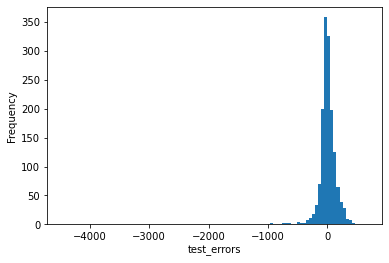

In [58]:
test_errors = lasso_pred - y_test
histograms = plt.hist(test_errors, bins=100)
plt.xlabel('test_errors')
plt.ylabel('Frequency')

Text(0, 0.5, 'test_errors')

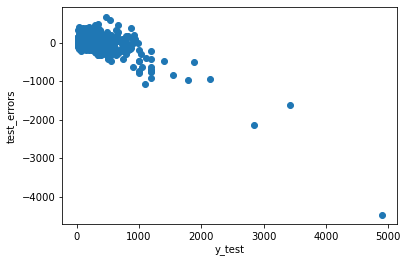

In [29]:
plt.plot(y_test, test_errors, 'o')
plt.xlabel('y_test')
plt.ylabel('test_errors')

Next, plot the scatter diagram between the true value and predictions of the proposed four models, respectively. The plot shows that Random Forest helps us converge the price prediction scatter.

In [60]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=42)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)

print('R2 socre: {}'.format(round(rf_r2, 3)))
print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(train_error/test_error, 3)))

R2 socre: 0.494
train error: 189.567 | test error: 195.949
train/test: 0.967


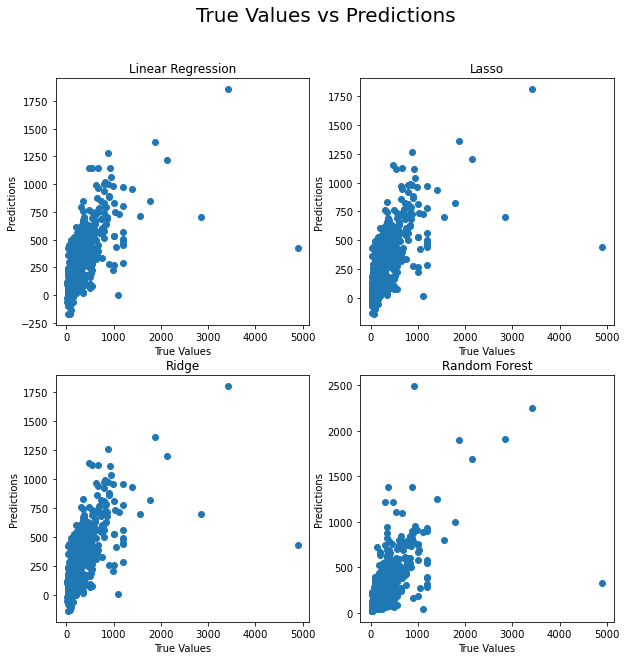

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 10))
fig.suptitle('True Values vs Predictions', size=20)

ax1.scatter(y_test, lr_pred)
ax1.set_title('Linear Regression')

ax2.scatter(y_test, lasso_pred)
ax2.set_title('Lasso')

ax3.scatter(y_test, ridge_pred)
ax3.set_title('Ridge')

ax4.scatter(y_test, rf_pred)
ax4.set_title('Random Forest')


for ax in fig.get_axes():
    ax.set(xlabel='True Values', ylabel='Predictions')


Comparing the Distribution of those two variables could find out that the price distribution shows a right skewness. However, most machine learning models assume the data or parameters obey a normal distribution. Taking the logarithm allows values more significant than the median to be reduced by a certain percentage, resulting in normally distributed data that enhance the prediction capacity.

d:\00-Software\Anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\00-Software\Anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log_Price Distribution')

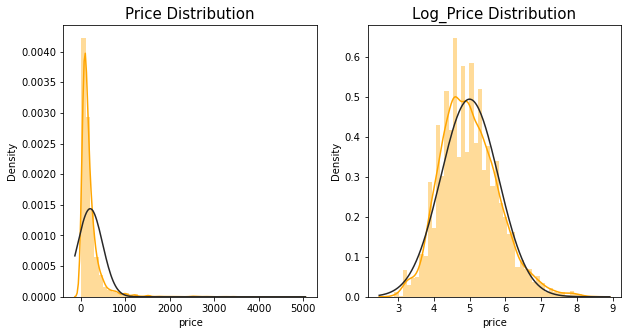

In [54]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.distplot(data['price'], color="orange", fit=norm)
plt.title("Price Distribution", size=15)

plt.subplot(122)
sns.distplot(np.log(data['price']), color="orange", fit=norm)
plt.title("Log_Price Distribution", size=15)

In [66]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

model = LinearRegression(fit_intercept=True).fit(X_train, y_train_log)
log_pred = model.predict(X_test)
log_test_errors_exp = mean_squared_error(y_test, np.exp(log_pred), squared=False)

print('ORIGINAL OLS ERROR')
print('-' * 40)
print('test error: {}\n'.format(test_error))
print('Log OLS ERROR')
print('-' * 40)
print('test error: {}'.format(log_test_errors_exp))

ORIGINAL OLS ERROR
----------------------------------------
test error: 195.949

Log OLS ERROR
----------------------------------------
test error: 210.90973501036137


By comparison, the **log_price** prediction actually gives a higher testing error. But one advantage of using log transformation is that the prediction errors is no longer heavily skewed.

Text(0, 0.5, 'Frequency')

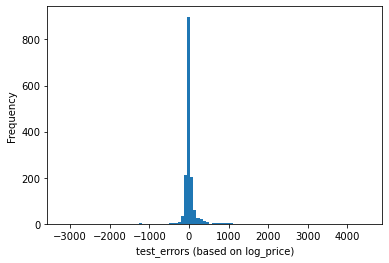

In [69]:
histograms = plt.hist(y_test - np.exp(log_pred), bins=100)
plt.xlabel('test_errors (based on log_price)')
plt.ylabel('Frequency')